For predicting the taxi Fare in new york using XGBoost, Linear Regression and Tensor FLow

In [26]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor

In [55]:

taxi_feature = pd.read_csv(r'C:\Exercise\TaxiFare\train.csv',index_col=0,nrows=300000)
taxi_feature_test = pd.read_csv(r'C:\Exercise\TaxiFare\test.csv')
print("Train")
print(taxi_feature.shape)

taxi_feature.dropna(axis=0,how='any')
taxi_feature_test.dropna(axis=0,how='any')

print(taxi_feature_test.shape)


Train
(300000, 7)
(9914, 7)


1) Check for data inconsistency(null or missing value and outliers). We clearly find outliers by seeing the describe function. latitude lies between -90 to +90 and longitude lies between -180 and +180
2) Dropping out -ve fare values which is not possible

In [28]:
print("\nTrain data stats\n")
print(taxi_feature.describe())
#print(taxi_feature.isnull().sum())
print("\nTest data stats\n")
print(taxi_feature_test.describe())
print(taxi_feature_test.head())


Train data stats



        fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  3.000000e+06      3.000000e+06     3.000000e+06       2.999977e+06   
mean   1.134246e+01     -7.250894e+01     3.992033e+01      -7.250740e+01   
std    9.828907e+00      1.320223e+01     8.644440e+00       1.308827e+01   
min   -6.200000e+01     -3.426609e+03    -3.488080e+03      -3.408430e+03   
25%    6.000000e+00     -7.399207e+01     4.073492e+01      -7.399139e+01   
50%    8.500000e+00     -7.398181e+01     4.075263e+01      -7.398016e+01   
75%    1.250000e+01     -7.396710e+01     4.076712e+01      -7.396367e+01   
max    1.273310e+03      3.439426e+03     2.912465e+03       3.457622e+03   

       dropoff_latitude  passenger_count  
count      2.999977e+06     3.000000e+06  
mean       3.991728e+01     1.684528e+00  
std        9.984419e+00     1.329084e+00  
min       -3.488080e+03     0.000000e+00  
25%        4.073402e+01     1.000000e+00  
50%        4.075315e+01     1.000000e+00  
75%  

In [6]:
def outliers(taxi_feature):#finding out outliers in latitude and longitude values
    
    taxi_feature.drop(taxi_feature[(taxi_feature.pickup_longitude < -180) & (taxi_feature.pickup_longitude > 180)].index,inplace=True)
    
    taxi_feature.drop(taxi_feature[(taxi_feature.dropoff_longitude > 180) & (taxi_feature.dropoff_longitude < -180)].index,inplace=True)
    
    taxi_feature.drop(taxi_feature[(taxi_feature.pickup_latitude > 90) & (taxi_feature.pickup_latitude < -90)].index,inplace=True)
    
    taxi_feature.drop(taxi_feature[(taxi_feature.dropoff_latitude > 90) & (taxi_feature.dropoff_latitude < -90)].index,inplace=True)
    
    if 'fare_amount' in taxi_feature:
        taxi_feature.drop(taxi_feature[taxi_feature.fare_amount < 0].index,inplace=True)
#New york city Latitude and longitude coordinates are: 40.730610, -73.935242.
#Boundary of New York City is (-75, -73, 40, 42)

    taxi_feature.drop(taxi_feature[(taxi_feature.pickup_longitude > 42) & (taxi_feature.pickup_longitude < 40)].index,inplace=True)
    
    taxi_feature.drop(taxi_feature[(taxi_feature.dropoff_longitude < 40) & (taxi_feature.dropoff_longitude > 42)].index,inplace=True)
    
    taxi_feature.drop(taxi_feature[(taxi_feature.pickup_latitude < -75) & (taxi_feature.pickup_latitude > -73)].index,inplace=True)
    
    taxi_feature.drop(taxi_feature[(taxi_feature.dropoff_latitude < -75) & (taxi_feature.dropoff_latitude > -73)].index,inplace=True)

    return taxi_feature

In [56]:
#call outliers function for traing and test dataset
taxi_feature = outliers(taxi_feature)
print("\nTrain data stats\n")
#print(taxi_feature.describe())
print(taxi_feature.shape)
print("\nTest data stats\n")
taxi_feature_test = outliers(taxi_feature_test)
#print(taxi_feature_test.describe())
print(taxi_feature_test.shape)


Train data stats

(299985, 7)

Test data stats

(9914, 7)



Split records for month day time format based on column 'pickup datetime'

In [57]:
#split pickupdatetime
taxi_feature['pickup_datetime'] = pd.to_datetime(taxi_feature['pickup_datetime'],
                                                 infer_datetime_format=True)
taxi_feature_test['pickup_datetime'] = pd.to_datetime(taxi_feature_test['pickup_datetime'],
                                                      infer_datetime_format=True)


In [59]:
print(taxi_feature.head())

                               fare_amount     pickup_datetime  \
key                                                              
2009-06-15 17:26:21.0000001            4.5 2009-06-15 17:26:21   
2010-01-05 16:52:16.0000002           16.9 2010-01-05 16:52:16   
2011-08-18 00:35:00.00000049           5.7 2011-08-18 00:35:00   
2012-04-21 04:30:42.0000001            7.7 2012-04-21 04:30:42   
2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00   

                               pickup_longitude  pickup_latitude  \
key                                                                
2009-06-15 17:26:21.0000001          -73.844311        40.721319   
2010-01-05 16:52:16.0000002          -74.016048        40.711303   
2011-08-18 00:35:00.00000049         -73.982738        40.761270   
2012-04-21 04:30:42.0000001          -73.987130        40.733143   
2010-03-09 07:51:00.000000135        -73.968095        40.768008   

                               dropoff_longitude  dropoff_la

In [43]:
#function to split datetime column into year/month/day/hour and day of week
def split_date(df):
    taxi_feature['year'] = df.pickup_datetime.dt.year
    taxi_feature['month'] = df.pickup_datetime.dt.month
    taxi_feature['day'] = df.pickup_datetime.dt.day
    taxi_feature['hour'] = df.pickup_datetime.dt.hour
    taxi_feature['day_of_week'] = df.pickup_datetime.dt.dayofweek    
    return taxi_feature

In [60]:
taxi_feature = split_date(taxi_feature)
#drop pickup datetime column
print(taxi_feature.head())


                               fare_amount     pickup_datetime  \
key                                                              
2009-06-15 17:26:21.0000001            4.5 2009-06-15 17:26:21   
2010-01-05 16:52:16.0000002           16.9 2010-01-05 16:52:16   
2011-08-18 00:35:00.00000049           5.7 2011-08-18 00:35:00   
2012-04-21 04:30:42.0000001            7.7 2012-04-21 04:30:42   
2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00   

                               pickup_longitude  pickup_latitude  \
key                                                                
2009-06-15 17:26:21.0000001          -73.844311        40.721319   
2010-01-05 16:52:16.0000002          -74.016048        40.711303   
2011-08-18 00:35:00.00000049         -73.982738        40.761270   
2012-04-21 04:30:42.0000001          -73.987130        40.733143   
2010-03-09 07:51:00.000000135        -73.968095        40.768008   

                               dropoff_longitude  dropoff_la

In [61]:
taxi_feature.drop('pickup_datetime',axis=1,inplace=True)


plot variation of rush hour  or weekday or no of passenger count which affects the price of taxi in New York

In [46]:
#function to split datetime column into year/month/day/hour and day of week
def split_date_test(df):
    taxi_feature_test['year'] = df.pickup_datetime.dt.year
    taxi_feature_test['month'] = df.pickup_datetime.dt.month
    taxi_feature_test['day'] = df.pickup_datetime.dt.day
    taxi_feature_test['hour'] = df.pickup_datetime.dt.hour
    taxi_feature_test['day_of_week'] = df.pickup_datetime.dt.dayofweek    
    return taxi_feature_test


In [62]:
taxi_feature_test = split_date_test(taxi_feature_test)
#drop pickup datetime column
taxi_feature_test.drop('pickup_datetime',axis=1,inplace=True)
print(taxi_feature_test.head())

                           key  pickup_longitude  pickup_latitude  \
0  2015-01-27 13:08:24.0000002        -73.973320        40.763805   
1  2015-01-27 13:08:24.0000003        -73.986862        40.719383   
2  2011-10-08 11:53:44.0000002        -73.982524        40.751260   
3  2012-12-01 21:12:12.0000002        -73.981160        40.767807   
4  2012-12-01 21:12:12.0000003        -73.966046        40.789775   

   dropoff_longitude  dropoff_latitude  passenger_count  year  month  day  \
0         -73.981430         40.743835                1  2015      1   27   
1         -73.998886         40.739201                1  2015      1   27   
2         -73.979654         40.746139                1  2011     10    8   
3         -73.990448         40.751635                1  2012     12    1   
4         -73.988565         40.744427                1  2012     12    1   

   hour  day_of_week  
0    13            1  
1    13            1  
2    11            5  
3    21            5  
4    21

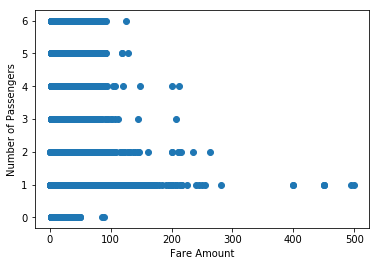

In [14]:

#plot for taxi fare price compared to rush hours/weekday 
%matplotlib inline 
plt.figure()
plt.scatter(taxi_feature['fare_amount'],taxi_feature['passenger_count'])
plt.xlabel("Fare Amount")
plt.ylabel("Number of Passengers")
plt.show()


We observe in the plot that the fare is highest for a single commuter. As the number of passengers increases in the cab, the fare goes down

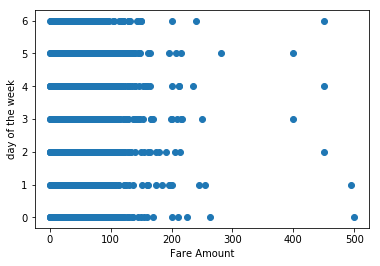

In [16]:
#plot for taxi fare price compared to day of the week 
plt.figure()
plt.scatter(taxi_feature['fare_amount'],taxi_feature['day_of_week'])
plt.ylabel("day of the week")
plt.xlabel("Fare Amount")
plt.show()

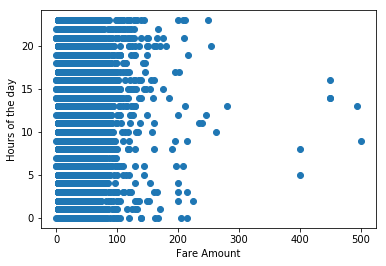

In [17]:
#plot for comparing hour of the day and fare amount
plt.figure()
plt.scatter(taxi_feature['fare_amount'],taxi_feature['hour'])
plt.ylabel("Hours of the day")
plt.xlabel("Fare Amount")
plt.show()

Use of haversine distance to calculate distance between 2 locations using latitude and longitude

Haversine
formula:
--- a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
--- c = 2 ⋅ atan2( √a, √(1−a) )
--- d = R ⋅ c
where	φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);
note that angles need to be in radians to pass to trig functions!

In [50]:
def dist_func(df):
    #haversine
    R = 6371
    delta_lat = np.radians(df['dropoff_latitude'] - df['pickup_latitude'])
    delta_long = np.radians(df['dropoff_longitude'] - df['pickup_longitude'])
    lat2 = np.radians(df['dropoff_latitude'])
    lat1 = np.radians(df['pickup_latitude'])
    a = (np.sin(delta_lat/2.0)**2) + (np.sin(delta_long/2.0)**2) * np.cos(lat2) * np.cos(lat1)
    c = 2 * (np.arctan2(np.sqrt(a),np.sqrt(1 - a))) 
    df['distance'] = R * c
    #euclidean
    #df['distance_e'] = np.sqrt(delta_lat**2 + delta_long ** 2)
    return df

In [69]:
taxi_feature = dist_func(taxi_feature)
#print(taxi_feature.head())
taxi_feature_test = dist_func(taxi_feature_test)
#print(taxi_feature_test.head())

In [70]:
taxi_feature['dropoff_longitude'].replace(np.nan,0,inplace=True)
taxi_feature['dropoff_latitude'].replace(np.nan,0,inplace=True)
taxi_feature['distance'].replace(np.nan,0,inplace=True)
taxi_feature.dropna(axis=0,how='any')
print(taxi_feature.isnull().sum())
print("\n")
#test data
taxi_feature_test['dropoff_longitude'].replace(np.nan,0,inplace=True)
taxi_feature_test['dropoff_latitude'].replace(np.nan,0,inplace=True)
taxi_feature_test['distance'].replace(np.nan,0,inplace=True)
taxi_feature_test.dropna(axis=0,how='any')
print(taxi_feature_test.isnull().sum())

fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
year                 0
month                0
day                  0
hour                 0
day_of_week          0
distance             0
distance_e           0
dtype: int64


key                  0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
year                 0
month                0
day                  0
hour                 0
day_of_week          0
distance             0
distance_e           0
dtype: int64


In [71]:
#taxi_feature= taxi_feature.reset_index()
taxi_feature_x = taxi_feature.iloc[:,1:]
taxi_feature_y = taxi_feature.iloc[:,0:1]
print("y: \n" + str(taxi_feature_y.head()))
print("x: \n" + str(taxi_feature_x.head()))

y: 
                               fare_amount
key                                       
2009-06-15 17:26:21.0000001            4.5
2010-01-05 16:52:16.0000002           16.9
2011-08-18 00:35:00.00000049           5.7
2012-04-21 04:30:42.0000001            7.7
2010-03-09 07:51:00.000000135          5.3
x: 
                               pickup_longitude  pickup_latitude  \
key                                                                
2009-06-15 17:26:21.0000001          -73.844311        40.721319   
2010-01-05 16:52:16.0000002          -74.016048        40.711303   
2011-08-18 00:35:00.00000049         -73.982738        40.761270   
2012-04-21 04:30:42.0000001          -73.987130        40.733143   
2010-03-09 07:51:00.000000135        -73.968095        40.768008   

                               dropoff_longitude  dropoff_latitude  \
key                                                                  
2009-06-15 17:26:21.0000001           -73.841610         40.712278   
2010

In [72]:
#split dataset
x_train, x_test,y_train, y_test = \
    train_test_split(taxi_feature_x,taxi_feature_y,random_state=0,test_size=0.2)

#linear regression
lm_same = LinearRegression()
lm_model_same = lm_same.fit(x_train,y_train)
lm_y_same = lm_model_same.predict(x_test)
print("coefficient :" + str(lm_model_same.coef_))
print("MSE:\n" + str(mse(y_test,lm_y_same)))
print("R2_score" + str(r2_score(y_test,lm_y_same)))


coefficient :[[ 1.57355506e-03 -1.52183016e-03  4.04290989e-03  3.47267365e-03
   8.93731996e-02  6.50955481e-01  1.04041211e-01  3.18160585e-03
  -3.04467582e-02 -7.25795354e-03  6.05753289e-04  2.88453448e-02]]
MSE:
96.53805651619108
R2_score0.013293400929922483


In [91]:
rf = RandomForestRegressor(random_state=23,min_samples_leaf=3,max_depth=20,max_features=11,bootstrap=True)
rf.fit(x_train, y_train)
rf_predict = rf.predict(x_test)
print("MSE:\n" + str(mse(y_test,rf_predict)))


C:\Users\Apurva Sinha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


MSE:
24.169709237740545


In [86]:
#final prediction
#print(taxi_feature_test.head())

#print(taxi_feature_test.keys())
y_pred_final = rf.predict(taxi_feature_test.iloc[:,1:])

print(y_pred_final)

[10.62994396 10.86030815  4.49933452 ... 54.11557029 21.86857143
  7.10871019]


In [82]:
#implement xgboost
xgb_model = XGBRegressor(learning_rate=0.1,subsample=0.6,max_delta_step=5,booster='gbtree')
xgb_model.fit(x_train,y_train)
xgb_predict = xgb_model.predict(x_test)
print("MSE of XGB :\n" + str(mse(y_test,xgb_predict)))

MSE of XGB :
24.515812874490408


In [76]:
# # set xgboost params  for k fold cv XGBOOST
# param = {
#     'max_delta_step': 3,  
#     'subsample': 0.6,  
#     'booster': 'gbtree',  
#     'learning_rate': 0.1
#         } 
# #implement xgboost
# x, y = taxi_feature.iloc[:,1:],taxi_feature.iloc[:,0:1]
# x_t,y_t = taxi_feature.iloc[:,1:],taxi_feature.iloc[:,0:1]
# # use DMatrix for xgbosot
# dtrain = xgb.DMatrix(taxi_feature, label=y)
# dtest = xgb.DMatrix(x_test, label=y_test)
# xgb_model_cv = xgb.cv(dtrain=dtrain,params=param,early_stopping_rounds=8,folds=4,metrics='rmse',num_boost_round=10)
# xgb_predict_cv = xgb_model_cv.predict(dtest)
# #print("MSE of XGB :\n" + str(mse(y_test,xgb_predict_cv)))

In [92]:
submission = pd.DataFrame(
    {'key': taxi_feature_test['key'],'fare_amount': rf.predict(taxi_feature_test.iloc[:,1:])},
    columns = ['key', 'fare_amount'])
#print(submission)
submission.to_csv('C:\Exercise\TaxiFare\submission1.csv', index = False)